![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn-generation/conditional-char-rnn-generation.ipynb) builds on this model to add a category as input

# Prepare data

Split into trainable chunks of 110 characters each. The first 10 characters will always be used as context, and the model will try to predict the next 100. There is no special consideration for where a chunk starts (it could be smart to e.g. always start on a newline).

In [1]:
import unicodedata
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

# Turn Unicode to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_characters
    )

file = unicodeToAscii(open('../data/shakespeare.txt').read())
file_len = len(file)

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

e cap your worship did bespeak.

PETRUCHIO:
Why, this was moulded on a porringer;
A velvet dish: fie, fie! 'tis lewd and filthy:
Why, 'tis a cockle or a walnut-shell,
A knack, a toy, a trick, a baby's 


In [3]:
# Turn string into set of of one-hot vectors
def make_input(string):
    tensor = torch.zeros(len(string), n_characters)
    for c in range(len(string)):
        i = all_characters.index(string[c])
        tensor[c][i] = 1
    return Variable(tensor)

# Turn string into list of longs
def make_target(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        i = all_characters.index(string[c])
        tensor[c] = i
    return Variable(tensor)

In [4]:
def random_training_set():    
    chunk = random_chunk()
    inp = make_input(chunk[:-1])
    target = make_target(chunk[1:])
    return inp, target

# Build the Model

This is a simple RNN with layers that encode to a smaller GRU, then decode back out

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [6]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = make_input(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
        
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = make_input(predicted_char)

    return predicted

In [7]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
n_epochs = 2000
print_every = 100
plot_every = 50
hidden_size = 50
n_layers = 2
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    # Read predictions
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output.view(-1), target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len
        
for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print('-->', evaluate('Wh', 100), '\n<--\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

0m 46s (100 5%) 3.3622
--> Wh ate aW pnrWsgmi uihto ti tl thov y ou
 oe to  ah n ttathi c  trnmThe
 e tlae e  M tttltpo  d  s n e 
<--

1m 32s (200 10%) 2.5020
--> Wh erte es il ke a fay ey hounk, rane uoir aitd yit hhor fet iou rose ton teh leh heh irpe hof thon wo 
<--

2m 17s (300 15%) 2.5799
--> What tars serob'cd os som asdce,

RIY IRENRTDNY:
Tol; hacte ane coms co ale if he,

ICEOTRKEN:

IN:

K 
<--

3m 3s (400 20%) 2.3707
--> Whab fhushs sone sreo he angake
Toor ansem.
Hef bitlen sere case bou res shangalt ho af theve hive,
Th 
<--

3m 49s (500 25%) 2.4492
--> Whod antE ontt teld ontt farlite odid pusgleef
Horde the gorlst I har,
Yor yamo taols!
 hame badren th 
<--

4m 35s (600 30%) 2.3445
--> Whrit there yy
Were pratirl ancing the shat bere in liou-Lome

OCECLICA:
A nath you
Whace karddire anc 
<--

5m 22s (700 35%) 2.2857
--> What so me lot moun thear woos seer to fond, wonle sored!

ITAS:
And heas's here nicpome bash, tho mad 
<--

6m 9s (800 40%) 2.1228
--> Whill to sull in

# Plotting the Network

Plotting the historical loss from all_losses shows the network learning:

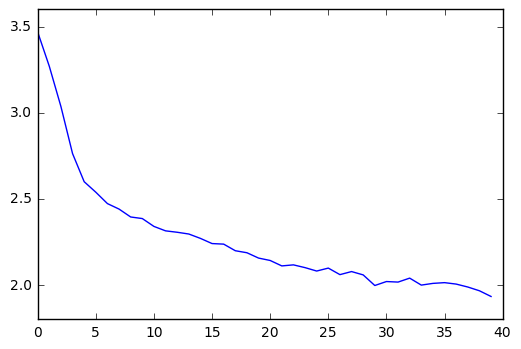

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [10]:
print(evaluate('Th', 500, temperature=0.8))

Thandyen he theser for the more
I the kins vering the be ar.

CELUETEL:
Nor this dud see the will so fare of age uigher
Thou Sather the not and so the hove his como.

CEMEMENMOUS:
There, the wand lenleing!d were bind,
What and the blase ceane gcand,
In she tame will this wad, what a date.

GMLIOLAS:
In have stremand hant of to you to!

LORWISO:
The goovers sucmt think blaes wear lear
To the waint, than to so thy is my ade entaneds.

CAMILENTEN:
Caystol, in as you be you of but, dive failite the,
I
